Paper: https://www.andrew.cmu.edu/user/lakoglu/pubs/StackOverflow-churn.pdf

Description of datasets: https://ia800107.us.archive.org/27/items/stackexchange/readme.txt

Site for download of datasets: https://archive.org/details/stackexchange

This code has 6 steps

    1. Load StackOverflow datasets as dataframe
    2. Extract and label the datasets for each tasks
    3. Extract & analyze features for each tasks
    4. Analyze features
    5. Train models for each tasks with the features
    6. Draw the graphs in the paper

1. Load StackOverflow datasets as dataframe

In [123]:
import sys
!{sys.executable} -m pip install xmltodict

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import xmltodict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [125]:
def load_from_google_drive(dir_id):
    files = []
    file_list = drive.ListFile({'q': "'{}' in parents".format(dir_id)}).GetList()
    for f in file_list:
        if f['title'] in ['Users.xml', 'Posts.xml',
                          'users_reduce.pkl', 'posts_reduce.pkl']\
                or 'pkl' in f['title'] or 'csv' in f['title']:
            print('  Load file: {}'.format(f['title']))
            f_ = drive.CreateFile({'id': f['id']})
            f_.GetContentFile(f['title'])
            files.append(f['title'])
    return files
  
  
# load_from_google_drive('1Fp_7GDH_t7xfnU8aXeKrcBC54_nECOcu')  ###| Full dataset
# load_from_google_drive('1haYAgCV-TqTMYIk8N4eGE9H4hY2np5xr')   ### Small dataset
load_from_google_drive('1CRE27AaxJuX-9Kxtgk2GnmxQt6ECHeJS')   ### Tiny dataset


  Load file: Users.xml
  Load file: Posts.xml


['Users.xml', 'Posts.xml']

In [0]:
# Read xml file and transform to pandas dataframe

def xml2df(xml_path):
    with open(xml_path) as f:
        dict_xml = xmltodict.parse(f.read())
        key = xml_path.split('.')[0].lower()
        xml_df = pd.DataFrame(dict_xml[key]['row'])
        xml_df.columns = xml_df.columns.str.lstrip('@')

        return xml_df

In [127]:
# 1. Read Users.xml

xml_path = 'Users.xml'
users_df = xml2df(xml_path)

# 2. Change data type of columns
users_df.head()
users_df['CreationDate'] = pd.to_datetime(users_df['CreationDate'])
users_df.dropna(subset=['Id'], inplace=True)
users_df['Id'] = users_df['Id'].astype(np.int64)
users_df.head()

,Id,Reputation,CreationDate,DisplayName,LastAccessDate,Location,AboutMe,Views,UpVotes,DownVotes,AccountId,WebsiteUrl,ProfileImageUrl
0,-1,1,2012-02-14 18:31:47.350,Community,2012-02-14T18:31:47.350,on the server farm,"<p>Hi, I'm not really a person.</p>\n\n<p>I'm ...",73,51,17,-1,NaN,NaN
1,2,101,2012-02-14 20:17:36.000,Geoff Dalgas,2014-08-29T13:45:59.997,"Corvallis, OR",<p>Developer on the Stack Overflow team. Find...,0,1,0,2,http://stackoverflow.com,https://i.stack.imgur.com/nDllk.png
2,3,3114,2012-02-14 20:20:16.000,Andy W,2017-10-28T00:57:06.677,"Dallas, TX, United States",<p>Assistant professor of criminology at the U...,8,291,15,298433,http://andrewpwheeler.wordpress.com/,NaN
3,5,1969,2012-02-14 20:22:08.000,Stefano Borini,2014-05-24T05:16:16.957,NaN,NaN,52,2,0,29108,http://ForTheScience.org,NaN
4,6,445,2012-02-14 20:22:35.000,Brian Ballsun-Stanton,2012-02-20T19:25:09.473,"Sydney, Australia","<p>Dr. Brian Ballsun-Stanton is a Philosopher,...",0,0,0,97049,http://denubis.wordpress.com,https://i.stack.imgur.com/jUaZ0.jpg


In [128]:
# 1. Read Posts.xml

xml_path = 'Posts.xml'
posts_df = xml2df(xml_path)

# 2. Change data type of columns
posts_df.head()
posts_df['CreationDate'] = pd.to_datetime(posts_df['CreationDate'])
posts_df.dropna(subset=['OwnerUserId'], inplace=True)
posts_df['OwnerUserId'] = posts_df['OwnerUserId'].astype(np.int64)
posts_df['PostTypeId'] = posts_df['PostTypeId'].astype(np.int64)
posts_df.head()

,Id,PostTypeId,CreationDate,Score,ViewCount,Body,OwnerUserId,LastEditorUserId,LastEditDate,LastActivityDate,Title,Tags,AnswerCount,CommentCount,ParentId,OwnerDisplayName,AcceptedAnswerId,FavoriteCount,ClosedDate,LastEditorDisplayName,CommunityOwnedDate
0,1,1,2012-02-14 20:39:10.140,4,114,<p>I would like to open the meta discussion on...,5,40592,2016-08-15T14:58:04.950,2016-08-15T14:58:04.950,Softness of the closing criteria,<discussion>,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,2012-02-14 20:41:04.273,3,108,"<p>Suppose user X comes in and ask ""How is the...",5,NaN,NaN,2012-02-14T21:06:26.337,"How should we behave for the ""reference"" quest...",<discussion>,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1,2012-02-14 21:37:15.053,3,67,<p>I think several questions are doing to be f...,30,NaN,NaN,2012-02-14T21:46:33.213,Is community wiki not available during beta?,<discussion><community-wiki>,1,0,NaN,NaN,5,1,NaN,NaN,NaN
4,5,2,2012-02-14 21:46:33.213,5,NaN,<p>Community wiki <em>questions</em> are a mod...,23,NaN,NaN,2012-02-14T21:46:33.213,NaN,NaN,NaN,1,4,NaN,NaN,NaN,NaN,NaN,NaN
5,6,2,2012-02-14 22:07:56.987,4,NaN,<p>I think it is a bit early to formulate poli...,31,NaN,NaN,2012-02-14T22:07:56.987,NaN,NaN,NaN,0,1,NaN,NaN,NaN,NaN,NaN,NaN


In [129]:
# Save and Load dataframe
from google.colab import drive
drive.mount('/content/gdrive')

def save_df(df, filename):
    df.to_pickle("{}.pkl".format(filename))

    
def load_df(filename):
    return pd.read_pickle("{}.pkl".format(filename))

  


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


2. Extract and label the datasets for each tasks

You should extract the dataset for the period of the dataset: July 31, 2008 ~  July 31, 2012 

There are 2 tasks:

    A. After a user's K-th post, predict how likely it is that the user will churn
    B. After the T-th day from the account creation of a user, predict how likely it is that the user will churn

In [130]:
# Users와 posts를 CreationDate 기준으로 filtering (July 31, 2008 ~  July 31, 2012)

start_time = pd.to_datetime('2008-07-31')
end_time = pd.to_datetime('2012-07-31')
end_time_2 = pd.to_datetime('2012-01-31')

posts_df = posts_df[(posts_df['CreationDate'] >= start_time) & (posts_df['CreationDate'] <= end_time)]
print(posts_df.columns)
users_df = users_df[(users_df['CreationDate'] >= start_time) & (users_df['CreationDate'] <= end_time_2)]
print(users_df.columns)

Index(['Id', 'PostTypeId', 'CreationDate', 'Score', 'ViewCount', 'Body',
       'OwnerUserId', 'LastEditorUserId', 'LastEditDate', 'LastActivityDate',
       'Title', 'Tags', 'AnswerCount', 'CommentCount', 'ParentId',
       'OwnerDisplayName', 'AcceptedAnswerId', 'FavoriteCount', 'ClosedDate',
       'LastEditorDisplayName', 'CommunityOwnedDate'],
      dtype='object')
Index(['Id', 'Reputation', 'CreationDate', 'DisplayName', 'LastAccessDate',
       'Location', 'AboutMe', 'Views', 'UpVotes', 'DownVotes', 'AccountId',
       'WebsiteUrl', 'ProfileImageUrl'],
      dtype='object')


In [131]:
def getIthOfPosts(posts):
    print('getIthOfPosts')
    posts.sort_values(by=['OwnerUserId', 'CreationDate'], inplace=True)
    posts.reset_index(level=0, inplace=True)
    posts['id_owner_time'] = posts.index
    first_posts = posts.groupby('OwnerUserId')['id_owner_time'].min().to_frame()
    tmp = posts.join(first_posts, on='OwnerUserId', how='inner', lsuffix='F', rsuffix='P')
    posts['ith'] = tmp['id_owner_timeF'] - tmp['id_owner_timeP'] + 1
    posts = posts.drop(['id_owner_time'], axis=1)
    return posts

posts_df = getIthOfPosts(posts_df)

getIthOfPosts


In [0]:
# Dataset in Task 1
#   Users: Post가 K개 이상인 user만 추출
#   Posts: User의 CreationDate 이후 K개의 posts만 추출

def getTask1Posts(posts, K=20):
    tmp = posts[posts['ith'] == K]['OwnerUserId'].to_frame()
    tmp = tmp.set_index('OwnerUserId')
    tmp = posts[posts['OwnerUserId'].isin(tmp.index)]
    return tmp[tmp['ith'] <= K]
#     return posts[posts['OwnerUserId'] > 0].groupby('OwnerUserId').filter(lambda post : len(post) >= K).groupby('OwnerUserId', as_index=False).apply(lambda owner : owner.nsmallest(K, 'CreationDate')).reset_index(level = 1, drop=True)

def getTask1Users(users, posts, K=20):
    users['num_posts'] = posts.groupby('OwnerUserId')['OwnerUserId'].count()
    users = users[users['num_posts'] >= K]
    return users
#      return pd.DataFrame(posts[posts['OwnerUserId'] > 0].groupby('OwnerUserId').filter(lambda post : len(post) >= K)['OwnerUserId'].drop_duplicates())
#     return posts[posts['OwnerUserId'] > 0].groupby('OwnerUserId').filter(lambda post : len(post) >= K).groupby('OwnerUserId')['CreationDate'].nsmallest(K).index.unique(level=0)

In [0]:
list_of_K = range(1, 21)
users_of_task1, posts_of_task1 = {}, {}


for K in list_of_K:
    posts_of_task1[K] = getTask1Posts(posts_df, K)
    users_of_task1[K] = getTask1Users(users_df, posts_df, K)

In [134]:
# Churn in Task 1
#   Churners: Users who did not post for at least 6 months from their K-th post 
#   Stayers:  Users who created at least one post within the 6 months from their K-th post

def prepareFeaturesTask1(users, posts, K):
    tmp = posts[posts['ith']==K]['OwnerUserId'].to_frame()
    tmp = tmp.set_index('OwnerUserId')
    posts = posts[posts['OwnerUserId'].isin(tmp.index)]

    posts_task = posts[posts['OwnerUserId'].isin(users.index)]
    posts_Kth_time = posts_task[posts_task['ith']==K]
    posts_Kth_time = posts_Kth_time.set_index('OwnerUserId')['CreationDate']
    posts_deadline = posts_Kth_time + pd.tseries.offsets.DateOffset(months=6)
    
    posts_stayer = posts_task[posts_task['ith'] > K].groupby('OwnerUserId')['CreationDate'].min().to_frame()
    posts_stayer = posts_stayer.merge(posts_deadline, on='OwnerUserId', how='left', suffixes=('_left', '_right'))
    
    posts_churner1 = posts_stayer[posts_stayer['CreationDate_left'] > posts_stayer['CreationDate_right']]
    posts_churner1['is_churn'] = 1
    posts_churner1 = posts_churner1[['is_churn']]
    posts_stayer = posts_stayer[posts_stayer['CreationDate_left'] <= posts_stayer['CreationDate_right']]
    posts_stayer['is_churn'] = 0    
    posts_stayer = posts_stayer[['is_churn']]
       
    posts_churner2 = posts_task[posts_task['ith'] >= K].groupby('OwnerUserId').count()
    posts_churner2 = posts_churner2[posts_churner2['CreationDate'] == 1][['CreationDate']]
    posts_churner2['is_churn'] = 1
    posts_churner2 = posts_churner2[['is_churn']]
    
    posts = pd.concat([posts_stayer, posts_churner1, posts_churner2])
    posts = posts.rename(columns={'OwnerUserId': 'Id'})
    users['is_churn'] = 0
    users.update(posts)
    return users

features_of_task1 = {}

for K in list_of_K:
    features_of_task1[K] = prepareFeaturesTask1(users_of_task1[K], posts_df, K)
   
  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[col] = expressions.where(mask, this, that)


In [0]:
# Dataset in Task 2
#   Users: Extract users who post at least 1
#   Posts: Extract posts which create before T day from the account creation of the owner

def getCreationDateOfOwner(users, posts):
    posts['DataframeIndex'] = posts.index
    posts['CreationDateOfOwner'] = posts.set_index('OwnerUserId')\
            .join(users, how='inner', rsuffix='OfOwner')\
            .set_index('DataframeIndex')['CreationDateOfOwner']
    posts = posts.drop(['DataframeIndex'], axis=1)
    return posts['CreationDateOfOwner']

  
def getTask2Posts(users, posts, T):
    if 'CreationDateOfUser' not in posts.columns:
        posts['CreationDateOfOwner'] = getCreationDateOfOwner(users, posts)
    observation_deadline = posts['CreationDateOfOwner'] + pd.offsets.Day(T)
    posts = posts[posts['CreationDate'] <= observation_deadline]
    return posts
  
def getTask2Users(users, posts):
    users['num_posts'] = posts.groupby('OwnerUserId')['OwnerUserId'].count()
    users = users[users['num_posts'] >= 1]
    return users
  
list_of_T = [7, 15, 30]
users_of_task2 = {}
posts_of_task2 = {}

for T in list_of_T:
    posts_of_task2[T] = getTask2Posts(users_df, posts_df, T)
    users_of_task2[T] = getTask2Users(users_df, posts_df)

In [0]:
# Churn in Task2
#   Churners: Users who did not post for at least 6 months from T days after account creation
#   Stayers:  Users who created at least one post within the 6 months from T days after account creation

def prepareFeaturesTask2(users, posts, T=30):
    if 'CreationDateOfUser' not in posts.columns:
        posts['CreationDateOfOwner'] = getCreationDateOfOwner(users, posts)
    users = getTask1Users(users, posts, K=1)
    observe_deadline = posts['CreationDateOfOwner'] + pd.offsets.Day(T)
    churn_deadline = observe_deadline + pd.tseries.offsets.DateOffset(months=6)
    posts_observed = posts[(posts['CreationDate'] <= observe_deadline) & (posts['CreationDate'] >= posts['CreationDateOfOwner'])]
    posts_after_observe = posts[(posts['CreationDate'] <= churn_deadline) & (posts['CreationDate'] > observe_deadline)]
    label_df = users.reindex((posts_observed.groupby('OwnerUserId')['OwnerUserId'].count() > 0).index)
    stayers = (posts_after_observe.groupby('OwnerUserId')['OwnerUserId'].count() > 0).index
    churners = list(set(label_df.index) - set(stayers))
    label_df['is_churn'] = 0.
    label_df.loc[churners, 'is_churn'] = 1.
    return label_df

features_of_task2 = {}
for T in list_of_T:
    features_of_task2[T] = prepareFeaturesTask2(users_of_task2[T], posts_df, T)


3. Extract features for each tasks

3-1. Temporal features

In [0]:
# Temporal features 1: gap1
def getTimeGap1OfUser(users, posts):
    creation_date_user = users['CreationDate']
    creation_date_first_post = posts.groupby('OwnerUserId')['CreationDate'].min()
    return (creation_date_first_post - creation_date_user).dt.total_seconds()


In [0]:
# Temporal features 2: gapK
def getTimeGapkOfPosts(posts, k):
    date_1 = posts[posts['ith'] == (k-1)].sort_values('OwnerUserId')
    date_2 = posts[posts['ith'] == k].sort_values('OwnerUserId')
    date_2 = date_2.set_index('OwnerUserId')
    date_1 = date_1.set_index('OwnerUserId')
    result = (date_2['CreationDate'] - date_1['CreationDate']).dt.total_seconds() / 60  
    return result

In [0]:
# Temporal features 3: last_gap
def getTimeLastGapOfPosts(posts):
    last_posts = posts.groupby('OwnerUserId')['CreationDate'].max().to_frame()
    tmp = posts.join(last_posts, on='OwnerUserId', how='inner', lsuffix='F', rsuffix='P')
    tmp = tmp[tmp['CreationDateF'] < tmp['CreationDateP']].groupby('OwnerUserId')['CreationDateF'].max().to_frame()
    return (last_posts['CreationDate'] - tmp['CreationDateF']).dt.total_seconds() / 60


In [0]:
# Temporal features 4: time_since_last_post
def getTimeSinceLastPost(users, posts, T):
    last_post_date = posts.groupby('OwnerUserId')['CreationDate'].max()
    creation_after_T_days_date = users['CreationDate'] + pd.offsets.Day(T)
    return (creation_after_T_days_date - last_post_date).dt.total_seconds() / 60


In [0]:
# Temporal features 5: mean_gap
def getTimeMeanGap(posts):
    last_post_date = posts.groupby('OwnerUserId')['CreationDate'].max()
    first_post_date = posts.groupby('OwnerUserId')['CreationDate'].min()
    num_posts = posts.groupby('OwnerUserId')['CreationDate'].count()
    return (last_post_date - first_post_date).dt.total_seconds() / 60 / num_posts


In [142]:
# Extract temporal features for task1
for K in list_of_K:
    features_of_task1[K]['gap1'] = getTimeGap1OfUser(users_of_task1[K], posts_of_task1[K])
    for k in range(2, K+1):
        features_of_task1[K]['gap{}'.format(k)] = getTimeGapkOfPosts(posts_of_task1[K], k)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs

K=1


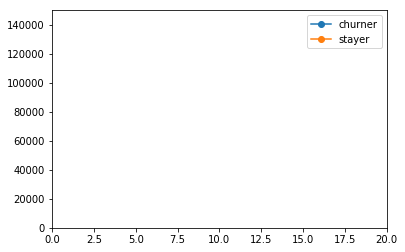

K=2


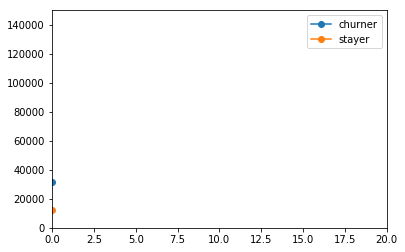

K=3


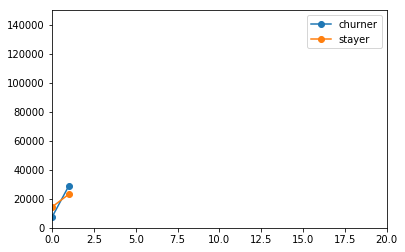

K=4


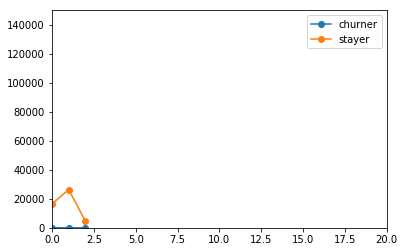

K=5


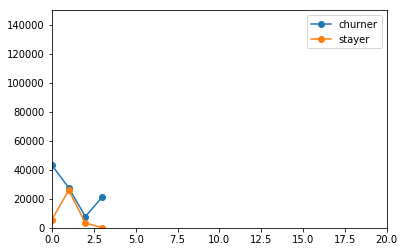

K=6


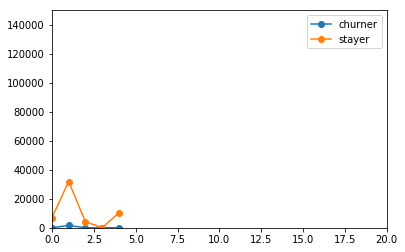

K=7


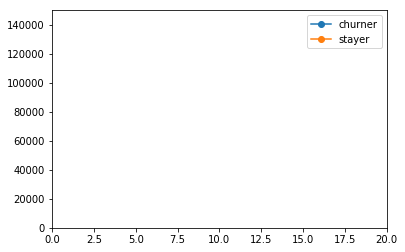

K=8


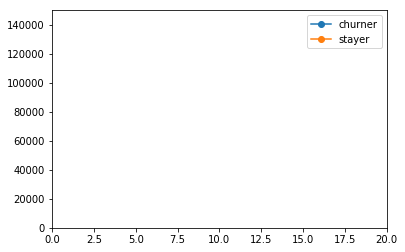

K=9


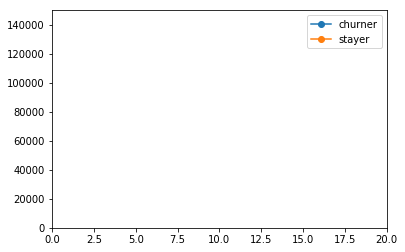

K=10


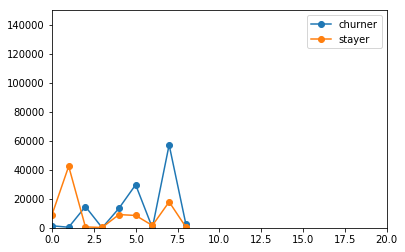

K=11


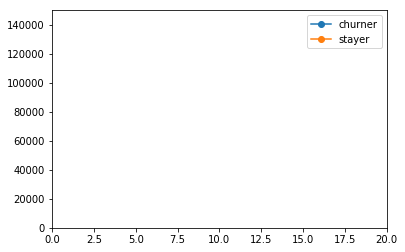

K=12


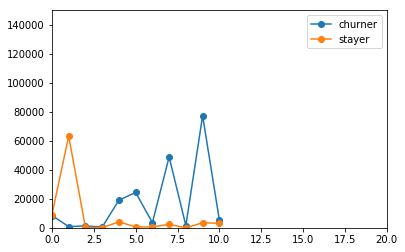

K=13


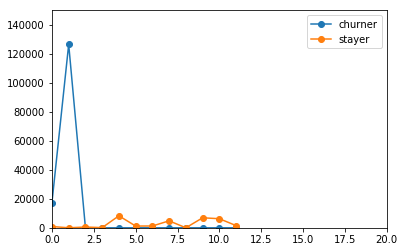

K=14


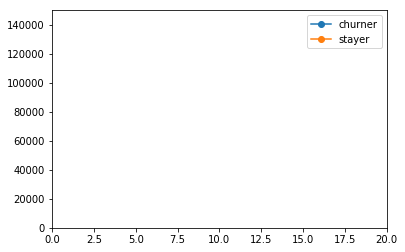

K=15


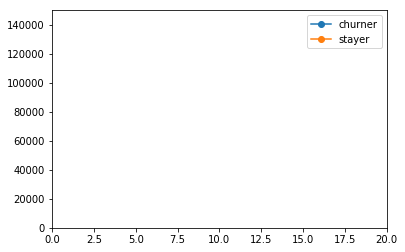

K=16


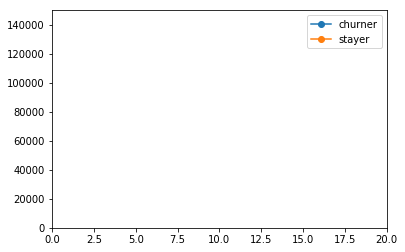

K=17


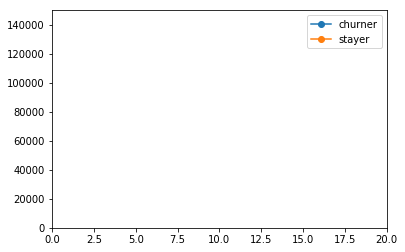

K=18


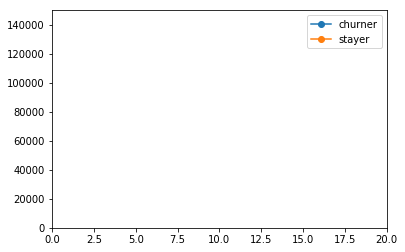

K=19


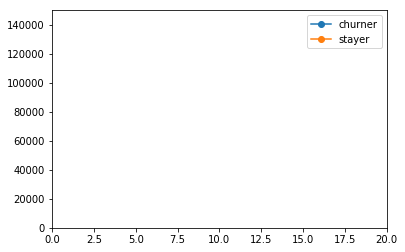

K=20


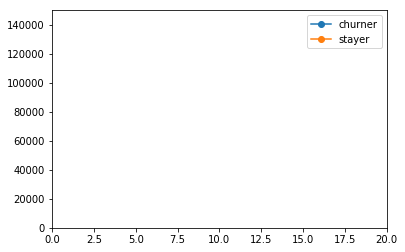

In [143]:
# Figure 2: Gap between posts
#    For a user who churns, gap between consecutive posts keeps increasing. 
#    Gaps for those who stay are much lower, and stabilize around 20,000 minutes,
#    indicating routine posting activity in every ≈2 weeks.
clist = []
slist = []
for K in list_of_K:
    subgroup = features_of_task1[K]
    churners_gap = []
    stayers_gap = []
    for i in range(2, K+1):
        gapK = 'gap{}'.format(i)
        sum_gapK = list(subgroup.groupby('is_churn')[gapK].sum())
        count_gapK = list(subgroup.groupby('is_churn')[gapK].count())
        if len(sum_gapK) < 2:
            break
        churners_gap.append(sum_gapK[1] / count_gapK[1])
        stayers_gap.append(sum_gapK[0] / count_gapK[0])

    clist.append(churners_gap)
    slist.append(stayers_gap)
    
    print("K={}".format(K))
    plt.plot(churners_gap, '-o', label='churner')
    plt.plot(stayers_gap, '-o', label='stayer')
    plt.legend()
    plt.axis((0,20,0,15e4))
    plt.show()

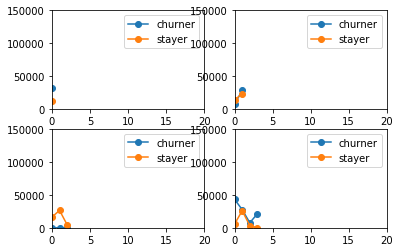

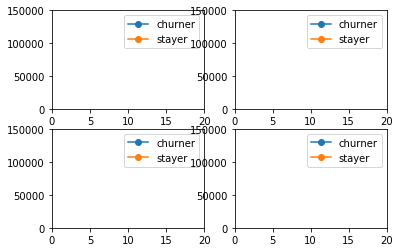

In [144]:
fig = plt.figure()
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)
axlist = [ax1, ax2, ax3, ax4]
for c, s, ax in zip(clist[1:], slist[1:], axlist):
    ax.plot(c, '-o', label='churner')
    ax.plot(s, '-o', label='stayer')
    ax.legend()
    ax.axis((0,20,0,15e4))
plt.show()

fig = plt.figure()
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)
axlist = [ax1, ax2, ax3, ax4]
for c, s, ax in zip(clist[-4:], slist[-4:], axlist):
    ax.plot(c, '-o', label='churner')
    ax.plot(s, '-o', label='stayer')
    ax.legend()
    ax.axis((0,20,0,15e4))
plt.show()

In [145]:
# Extract temporal features for task2
for T in list_of_T:
    users, posts = users_of_task2[T], posts_of_task2[T]
    features_of_task2[T]['gap1'] = getTimeGap1OfUser(users, posts)
    features_of_task2[T]['last_gap'] = getTimeLastGapOfPosts(posts).fillna(features_of_task2[T]['gap1'])
    #features_of_task2[T]['last_gap'] = getTimeLastGapOfPosts(posts).fillna(0)
    features_of_task2[T]['time_since_last_post'] = getTimeSinceLastPost(users, posts, T)
    features_of_task2[T]['mean_gap'] = getTimeMeanGap(posts)
  


ValueError: ignored

3-2. Frequency features

In [0]:
# Frequency features 1: num_answers
# Frequency features 2: num_questions
def getNumAnswers(posts):
    answers = posts[posts['PostTypeId'] == 2]
    return answers.groupby('OwnerUserId')['OwnerUserId'].count()

def getNumQuestions(posts):
    questions = posts[posts['PostTypeId'] == 1]
    return questions.groupby('OwnerUserId')['OwnerUserId'].count()


In [0]:
# Frequency features 3: ans_ques_ratio
def getAnsQuesRatio(num_answers, num_questions):
    # Use Laplace Smoothing
    return (num_answers + 1) / (num_questions + 1)


In [0]:
# Frequency features 4: num_posts
def getNumPosts(posts):
    return posts.groupby('OwnerUserId')['OwnerUserId'].count().astype('float')

In [0]:
# Extract frequency features of task1
for K in list_of_K:
    users, posts = users_of_task1[K], posts_of_task1[K]
    features_of_task1[K]['num_answers'] = getNumAnswers(posts)
    features_of_task1[K]['num_questions'] = getNumQuestions(posts)
    features_of_task1[K] = features_of_task1[K].fillna({'num_answers':0, 'num_questions':0})
    features_of_task1[K]['ans_que_ratio'] = \
        getAnsQuesRatio(features_of_task1[K]['num_answers'], features_of_task1[K]['num_questions'])

In [0]:
# Extract frequency features of task2
for T in list_of_T:
    users, posts = users_of_task2[T], posts_of_task2[T]
    features_of_task2[T]['num_answers'] = getNumAnswers(posts)
    features_of_task2[T]['num_questions'] = getNumQuestions(posts)
    features_of_task2[T] = features_of_task2[T].fillna({'num_answers':0,'num_questions':0})
    features_of_task2[T]['ans_que_ratio'] = \
        getAnsQuesRatio(features_of_task2[T]['num_answers'], features_of_task2[T]['num_questions'])
    features_of_task2[T]['num_posts'] = getNumPosts(posts)

In [0]:
# Figure 3: # Answers vs Churn probability
#    The probability of churning for a user decreases the more answers s/he provides.
#    It is even lower if s/he asks more questions alongside.

min_num_users = 50
for T in list_of_T:
    task2 = features_of_task2[T]
    for num_que_ask in range(5):
        subgroup = task2[task2['num_questions'] == num_que_ask]
        churn_probs = []
        num_answers = list(set(subgroup['num_answers']))
        num_answers.sort()
        for num_ans in num_answers:
            subsubgroup = subgroup[subgroup['num_answers'] == num_ans]
            prob = sum(subsubgroup['is_churn']) / subsubgroup.shape[0]
            if subsubgroup.shape[0] >= min_num_users:
                churn_probs.append((num_ans, prob))

        plt.plot([np.log10(x[0]+1) for x in churn_probs],
                 [np.log10(x[1]+0.01) for x in churn_probs],
                 '-o',
                 label='{} ques asked'.format(num_que_ask))
    print("# Answers vs Churn probability")
    plt.legend()
    plt.axis((0,2,-2,0))
    plt.show()

3-3. Knowledge features

In [0]:
# For the fast extraction, prepare questions x answers
def preprocessForKnowledgeFeaturesForTask1(users, posts, all_posts):
    answers = posts[posts['PostTypeId'] == 2]
    questions = posts[posts['PostTypeId'] == 1]
    all_answers = all_posts[all_posts['PostTypeId'] == 2]
    all_questions = all_posts[all_posts['PostTypeId'] == 1]

    qnta = all_answers.set_index('ParentId')\
        .join(questions, how='inner',\
              lsuffix='A', rsuffix='Q')
    tqna = answers.set_index('ParentId')\
        .join(all_questions, how='inner',\
              lsuffix='A', rsuffix='Q')
    return answers, questions, qnta, tqna

In [0]:
# For the fast extraction, prepare questions x answers
def preprocessForKnowledgeFeaturesForTask2(users, posts):
    answers = posts[posts['PostTypeId'] == 2]
    questions = posts[posts['PostTypeId'] == 1]
    qna = answers\
        .set_index('ParentId').join(questions, how='inner',\
                                    lsuffix='A', rsuffix='Q')
    return answers, questions, qna, qna

In [0]:
# Knowledge features 1: accepted_answerer_rep
def getRepOfAcceptedAnswerer(users, answers, questions, qnta, tqna):
    reputations = users.loc[:, ['Reputation']]
    rep_accepted_ans = qnta[qnta['AcceptedAnswerIdQ'] == qnta['IdA']]\
        .set_index('OwnerUserIdA')\
        .join(reputations, how='inner')\
        .groupby('OwnerUserIdQ')['Reputation'].mean()
    return rep_accepted_ans


In [0]:
# Knowledge features 2: max_rep_answerer 
def getMaxRepAmongAnswerer(users, answers, questions, qnta, tqna):
    reputations = users.loc[:, ['Reputation']]
    rep_max_ans = qnta.set_index('OwnerUserIdA')\
        .join(reputations, how='inner')\
        .groupby('OwnerUserIdQ')['Reputation'].max()
    return rep_max_ans


In [0]:
# Knowledge features 3: num_que_answered
def getNumQueAnswered(users, answers, questions, qnta, tqna):
    # number of questions posted by the user that got answered
    #questions = posts[posts['PostTypeId'] == 1]
    answered_questions = questions[questions['AnswerCount'] > 0]
    return answered_questions.groupby('OwnerUserId')['AnswerCount'].count()


In [0]:
# Knowledge features 4: time_for_first_ans
def getTimeForFirstAns(users, answers, questions, qnta, tqna):
    tmp =  qnta[qnta['CreationDateQ'] < qnta['CreationDateA']]
    tmp['time_for_ans'] = (tmp['CreationDateA'] - tmp['CreationDateQ']).dt.total_seconds() / 60
    questions['time_for_first_ans'] = tmp.groupby(by=tmp.index)['time_for_ans'].min()
    return questions.groupby('OwnerUserId')['time_for_first_ans'].mean()


In [0]:
# Knowledge features 5: rep_questioner
def getAvgRepOfQuestioner(users, answers, questions, qnta, tqna):
    # Avg. reputation of the user whose question was answered
    reputations = users.loc[:, ['Reputation']]
    rep_accepted_ans = tqna.set_index('OwnerUserIdQ')\
        .join(reputations, how='inner')\
        .groupby('OwnerUserIdA')['Reputation'].mean()
    return rep_accepted_ans


In [0]:
# Knowledge features 6: rep_answerers
def getAvgRepOfAnswerer(users, answers, questions, qnta, tqna):
    # Avg. reputation of the users who answered the question
    reputations = users.loc[:, ['Reputation']]
    rep_accepted_ans = qnta.set_index('OwnerUserIdA')\
        .join(reputations, how='inner')\
        .groupby('OwnerUserIdQ')['Reputation'].mean()
    return rep_accepted_ans


In [0]:
# Knowledge features 7: rep_co_answerers
def getAvgRepOfCoAnswerer(users, answers, questions, qnta, tqna):
    reputations = users.loc[:, ['Reputation']]    
    rep_ans = answers.set_index('OwnerUserId')\
        .join(reputations, how='inner')\
        .set_index('ParentId')\
        .join(questions, how='inner', lsuffix='A', rsuffix='Q')
    avg_rep_ans = rep_ans.groupby(by=rep_ans.index)['Reputation'].mean()
    rep_co_answerer = answers.set_index('ParentId')\
        .join(avg_rep_ans, how='inner')\
        .set_index('OwnerUserId')
    return rep_co_answerer.groupby(by=rep_co_answerer.index)['Reputation'].mean()


In [0]:
# Knowledge features 8: num_answers_recvd
def getAvgNumAnsReceived(users, answers, questions, qnta, tqna):
    #questions = posts[posts['PostTypeId'] == 1]
    return questions.fillna({'AnswerCount': 0}).groupby('OwnerUserId')['AnswerCount'].mean()


In [0]:
# Extract knowledge features of task 1
for K in list_of_K:
    print("Extract knowledge features of task1(K=",K,")")
    users, posts = users_of_task1[K], posts_of_task1[K]
    answers, questions, qnta, tqna = preprocessForKnowledgeFeaturesForTask1(users, posts, posts_df)
    features_of_task1[K]['accepted_answerer_rep'] = getRepOfAcceptedAnswerer(users, answers, questions,  qnta, tqna)
    features_of_task1[K]['max_rep_answerer'] = getMaxRepAmongAnswerer(users, answers, questions,  qnta, tqna)
    features_of_task1[K]['num_que_answered'] = getNumQueAnswered(users, answers, questions,  qnta, tqna)
    features_of_task1[K]['time_for_first_ans'] = getTimeForFirstAns(users, answers, questions, qnta, tqna)
    features_of_task1[K]['rep_questioner'] = getAvgRepOfQuestioner(users, answers, questions, qnta, tqna)
    features_of_task1[K]['rep_answerers'] = getAvgRepOfAnswerer(users, answers, questions, qnta, tqna)
    features_of_task1[K]['rep_co_answerers'] = getAvgRepOfCoAnswerer(users, answers, questions, qnta, tqna)
    features_of_task1[K]['num_answers_recvd'] = getAvgNumAnsReceived(users, answers, questions, qnta, tqna)

In [0]:
for T in list_of_T:
    print("Extract knowledge features of task2(T=)",T,")")
    users, posts = users_of_task2[T], posts_of_task2[T]
    answers, questions, qna, qna1 = preprocessForKnowledgeFeaturesForTask2(users, posts)
    features_of_task2[T]['accepted_answerer_rep'] = getRepOfAcceptedAnswerer(users, answers, questions, qna, qna1)
    features_of_task2[T]['max_rep_answerer'] = getMaxRepAmongAnswerer(users, answers, questions, qna, qna1)
    features_of_task2[T]['num_que_answered'] = getNumQueAnswered(users, answers, questions, qna, qna1)
    features_of_task2[T]['time_for_first_ans'] = getTimeForFirstAns(users, answers, questions, qna, qna1)
    features_of_task2[T]['rep_questioner'] = getAvgRepOfQuestioner(users, answers, questions, qna, qna1)
    features_of_task2[T]['rep_answerers'] = getAvgRepOfAnswerer(users, answers, questions, qna, qna1)
    features_of_task2[T]['rep_co_answerers'] = getAvgRepOfCoAnswerer(users, answers, questions, qna, qna1)
    features_of_task2[T]['num_answers_recvd'] = getAvgNumAnsReceived(users, answers, questions, qna, qna1)

In [0]:
# Figure 4: K vs Time taken for the first answer to arrive
#  The more the time taken for a user to receive an answer, 
#  the lesser the satisfaction level and the more the chances of churning.
churners_time = []
stayers_time = []
for K in list_of_K:
    subgroup = features_of_task1[K]
    churners = subgroup[subgroup['is_churn'] == 1][subgroup['time_for_first_ans'] > 0] 
    stayers = subgroup[subgroup['is_churn'] == 0][subgroup['time_for_first_ans'] > 0]
    churners_time.append(churners['time_for_first_ans'].mean())
    stayers_time.append(stayers['time_for_first_ans'].mean())
    

plt.plot(churners_time, '-o', label='churner')
plt.plot(stayers_time, '-o', label='stayer')
plt.legend()
# plt.axis((0,20,8e3,22e3))
plt.show()

3-4. Speed features

In [0]:
# Speed features 1: answering_speed
def getAnsweringSpeed(posts):
    posts['answering_speed'] = posts[posts['PostTypeId'] == 2].apply(lambda post : post['CreationDate'] - posts_df[posts_df['Id'] == post['ParentId']]['CreationDate'])
    return posts


3-5. Quality features

In [0]:
# Quality features 1: ans_score
# Quality features 2: que_score
def getScoreOfAnswers(posts):
    posts['ans_score'] = posts[posts['OwnerUserId'] > 0].groupby('OwnerUserId')[posts['PostTypeId'] == 2]['Score'].mean()
    return posts

def getScoreOfQuestions(posts):
    posts['que_score'] = posts[posts['OwnerUserId'] > 0].groupby('OwnerUserId')[posts['PostTypeId'] == 1]['Score'].mean()
    return posts


3-6. Consistency features

In [0]:
# Consistency features 1: ans_stddev
# Consistency features 2: que_stddev
def getStdevOfScoresOfAnswers(posts):
    posts['ans_stddev'] = posts[posts['OwnerUserId'] > 0].groupby('OwnerUserId')[posts['PostTypeId'] == 2]['Score'].std()
    return posts

def getStdevOfScoresOfQuestions(posts):
    posts['que_stddev'] = posts[posts['OwnerUserId'] > 0].groupby('OwnerUserId')[posts['PostTypeId'] == 1]['Score'].std()
    return posts


3-7. Gratitude features

In [0]:
# Gratitude features 1: ans_comments
# Gratitude features 2: que_comments
def getAvgNumOfAnswers(posts):
    posts['ans_comments'] = posts[posts['OwnerUserId'] > 0].groupby('OwnerUserId')[posts['PostTypeId'] == 2]['CommentCount'].mean()
    return posts

def getAvgNumOfQuestions(posts):
    posts['que_comments'] = posts[posts['OwnerUserId'] > 0].groupby('OwnerUserId')[posts['PostTypeId'] == 1]['CommentCount'].mean()
    return posts


3-8. Competitiveness features

In [0]:
# Competitiveness features 1: relative_rank_pos
def getRelRankPos(posts):
    return


3-9. Content features

In [0]:
# Content features 1: ans_length
# Content features 2: que_length
def getLengthOfAnswers(posts):
    posts['ans_length'] = posts[posts['OwnerUserId'] > 0].groupby('OwnerUserId')[posts['PostTypeId'] == 2]['Body'].apply(lambda content : len(content)).mean()
    return posts

def getLengthOfQuestions(posts):
    posts['que_length'] = posts[posts['OwnerUserId'] > 0].groupby('OwnerUserId')[posts['PostTypeId'] == 1]['Body'].apply(lambda content : len(content)).mean()
    return posts

3-10. Extract all features for each tasks

In [0]:
def getFeatures(features, users, posts, task, K=None, T=None):
    assert(task in [1,2])
    
    if -1 in features.index:
        features = features.drop([-1])
    
    return features

In [0]:
common_features = ['getTimeGap1OfUser',
                   'getNumAnswers', 'getNumQuestions','getAnsQuesRatio',
                   'getAnsweringSpeed',
                   'getScoreOfAnswers', 'getScoreOfQuestions',
                   'getStdevOfScoresOfAnswers', 'getStdevOfScoresOfQuestions',
                   'getAvgNumOfAnswers', 'getAvgNumOfQuestions',
                   'getRelRankPos',
                   'getLengthOfAnswers', 'getLengthOfQuestions',
                   'getRepOfAcceptedAnswerer', 'getMaxRepAmongAnswerer', 'getNumQueAnswered', 'getTimeForFirstAns', 'getAvgRepOfQuestioner', 'getAvgRepOfAnswerer', 'getAvgRepOfCoAnswerer', 'getAvgNumAnsReceived']
task1_features = common_features + ['getTimeGapsOfPosts']
for K in range(1, 20+1):
    task1_features.append()
    
task2_features = common_features + ['getTimeLastGapOfPosts', 'getTimeSinceLastPost', 'getTimeMeanGap', 'getNumPosts']
for T in [7, 15, 30]:
    task2_features.append()

4. Analyze features


In [0]:
# Figure 2: Gap between posts
#    For a user who churns, gap between consecutive posts keeps increasing. 
#    Gaps for those who stay are much lower, and stabilize around 20,000 minutes,
#      indicating routine posting activity in every ≈2 weeks.

for K in range(2, 21):
    pass

In [0]:
# Figure 3: # Answers vs Churn probability
#    The probability of churning for a user decreases the more answers s/he provides.
#    It is even lower if s/he asks more questions alongside.

for features in task2_features:
    pass

In [0]:
# Figure 4: K vs Time taken for the first answer to arrive
#    The more the time taken for a user to receive an answer, 
#      the lesser the satisfaction level and the more the chances of churning.


5. Train models for each tasks with the features

    1. Decision Tree
    2. SVM (Linear)
    3. SVM (RBF)
    4. Logistic Regression
    

In [0]:
# Table 2: Performance on Task 1

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

seed = 1234

for i, features in enumerate(task1_features):
    pass

In [0]:
# Table 3: Performance on Task 2

for i, features in enumerate(task2_features):
    pass

6. Draw the graphs in the paper


In [0]:
# Table 4: Temporal Features Analysis

for i, features in enumerate(task1_features):
    pass

In [0]:
# Figure 5: Churn prediction accuracy when features from each category are used in isolation
